In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

In [ ]:
#Logistic Regression
df = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

cols = [
    'stars', 'review_count', 'latitude', 'longitude',
    'Alcohol', 'BikeParking', 'RestaurantsDelivery', 
    'RestaurantsTakeOut', 'RestaurantsPriceRange2'
]
df = df[cols]

# Converter colunas categóricas
df['Alcohol'] = df['Alcohol'].map({'None': 0, 'Beer&Wine': 1, 'Full_Bar': 2, 'Unknown': 1})
df['BikeParking'] = df['BikeParking'].fillna(0).astype(int)
df['RestaurantsDelivery'] = df['RestaurantsDelivery'].map({'True': 1, 'False': 0, 'Unknown': 0})
df['RestaurantsTakeOut'] = df['RestaurantsTakeOut'].map({'True': 1, 'False': 0, 'Unknown': 0})

df = df.dropna(subset=['RestaurantsPriceRange2'])

X = df.drop('RestaurantsPriceRange2', axis=1)
y = df['RestaurantsPriceRange2'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
print(y_test.value_counts())  # Antes e depois do balanceamento

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['stars', 'review_count', 'latitude', 'longitude']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('passthrough', 'passthrough')
        ]), ['Alcohol', 'BikeParking', 'RestaurantsDelivery', 'RestaurantsTakeOut'])
    ]
)

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1))
])


RestaurantsPriceRange2
2    21001
1     7476
3     1334
4      238
Name: count, dtype: int64


In [26]:
y_train_bin = label_binarize(y_train, classes=[1, 2, 3, 4])
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])

pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', OneVsRestClassifier(LogisticRegression(class_weight='balanced', max_iter=1000, random_state=1)))
])

pipeline.fit(X_train, y_train_bin)

y_pred = pipeline.predict(X_test)
y_probs = pipeline.predict_proba(X_test)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['RestaurantsDelivery' 'RestaurantsTakeOut']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


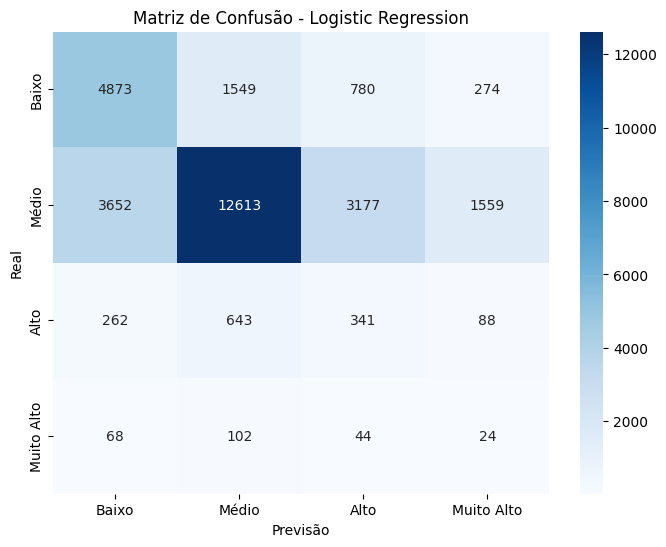

Relatório de Classificação (Logistic Regression):
              precision    recall  f1-score   support

           1       0.55      0.65      0.60      7476
           2       0.85      0.60      0.70     21001
           3       0.08      0.26      0.12      1334
           4       0.01      0.10      0.02       238

    accuracy                           0.59     30049
   macro avg       0.37      0.40      0.36     30049
weighted avg       0.73      0.59      0.64     30049



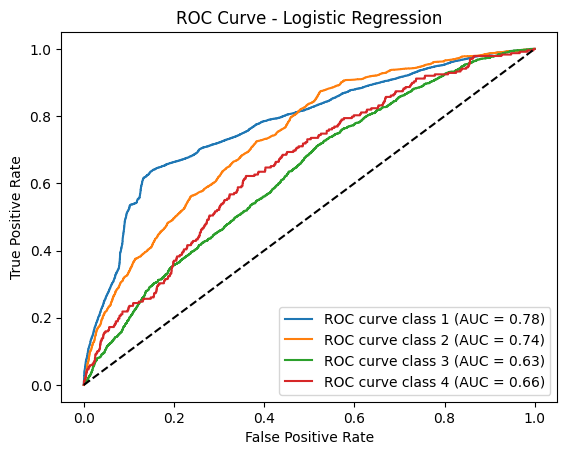

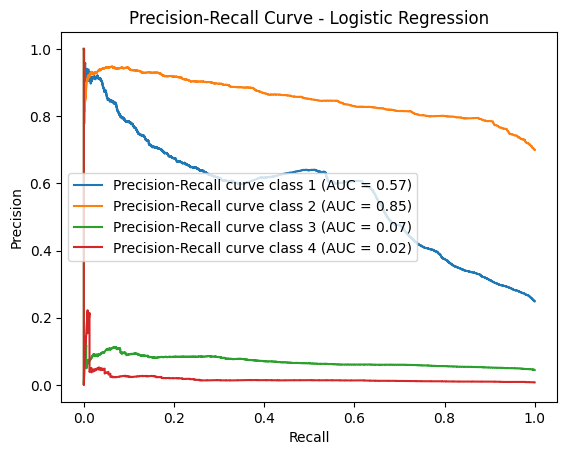

RestaurantsPriceRange2
2    21001
1     7476
3     1334
4      238
Name: count, dtype: int64


In [30]:
cm = confusion_matrix(y_test, y_pred.argmax(axis=1) + 1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baixo', 'Médio', 'Alto', 'Muito Alto'], yticklabels=['Baixo', 'Médio', 'Alto', 'Muito Alto'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Logistic Regression')
plt.show()

print("Relatório de Classificação (Logistic Regression):")
print(classification_report(y_test, y_pred.argmax(axis=1) + 1))

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve class {i+1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

# Precision-Recall Curve
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_probs[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

plt.figure()
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Precision-Recall curve class {i+1} (AUC = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression')
plt.legend()
plt.show()
print(y_test.value_counts())  # Antes e depois do balanceamento


C:\Users\User\AppData\Local\Temp\ipykernel_1016\548667045.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['city'] = label_encoder.fit_transform(X['city'])


Melhores Parâmetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Relatório de Classificação (com melhores parâmetros):
              precision    recall  f1-score   support

         1.0       0.41      0.45      0.43      7476
         2.0       0.78      0.63      0.69     21001
         3.0       0.07      0.19      0.11      1334
         4.0       0.02      0.08      0.03       238

    accuracy                           0.56     30049
   macro avg       0.32      0.34      0.31     30049
weighted avg       0.65      0.56      0.60     30049

Acurácia (com melhores parâmetros):
0.560384704981863


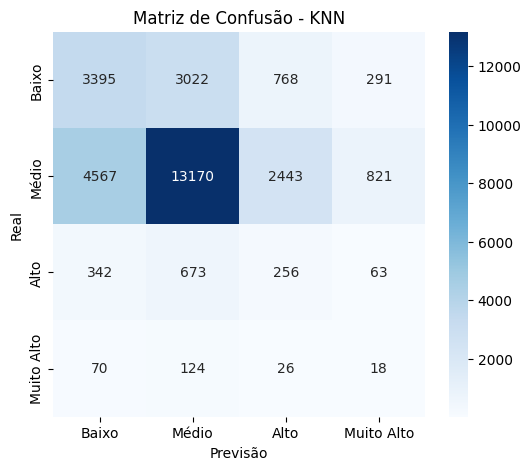

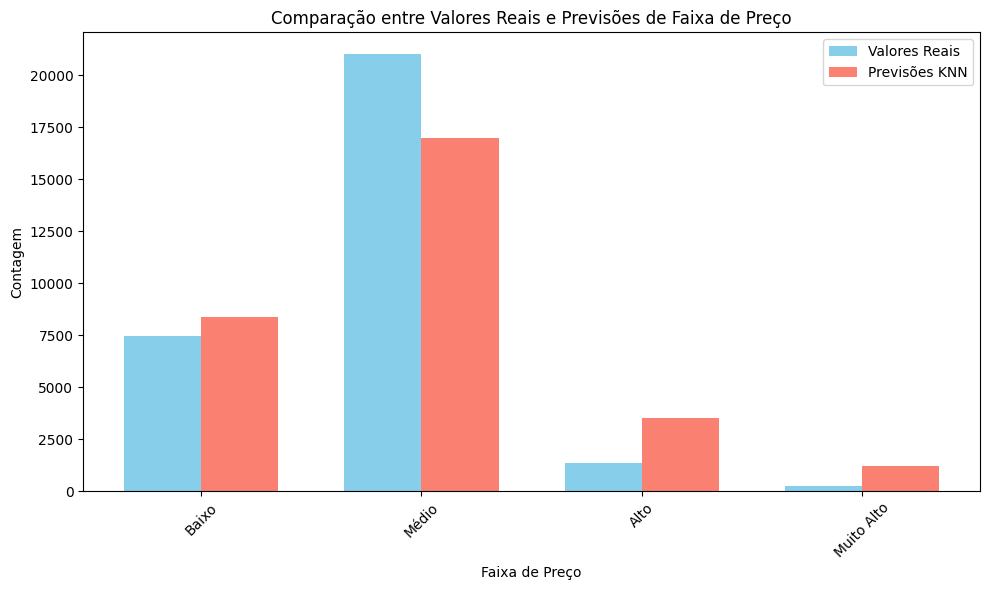

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# Carregar o dataset
df_negocios = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

features = ['stars', 'review_count', 'latitude', 'longitude', 'city']
X = df_negocios[features]
y = df_negocios['RestaurantsPriceRange2']

# Codificação da coluna categórica 'city'
label_encoder = LabelEncoder()
X['city'] = label_encoder.fit_transform(X['city'])

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Correção: Agora a divisão dos dados é idêntica à da Regressão Logística
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=1)

# ✅ Correção: Aplicação de SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Modelo Knn
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20, 30, 50],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

# Realizar GridSearch com validação cruzada
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhores Parâmetros:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Relatório de Classificação (com melhores parâmetros):")
print(classification_report(y_test, y_pred))
print("Acurácia (com melhores parâmetros):")
print(accuracy_score(y_test, y_pred))

# 🔵 Adicionar Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

# Exibir Matriz de Confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

# Gráfico de comparação entre valores reais e previsões
real_counts = y_test.value_counts()
pred_counts = pd.Series(y_pred).value_counts()

width = 0.35 
plt.figure(figsize=(10, 6))

plt.bar(real_counts.index - width/2, real_counts, width=width, label='Valores Reais', color='skyblue')
plt.bar(pred_counts.index + width/2, pred_counts, width=width, label='Previsões KNN', color='salmon')
plt.title("Comparação entre Valores Reais e Previsões de Faixa de Preço")
plt.xlabel("Faixa de Preço")
plt.ylabel("Contagem")
plt.xticks(range(1, 5), labels, rotation=45)  # Corrigido range para 1-4
plt.legend()
plt.tight_layout()
plt.show()


Melhores Parâmetros: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Relatório de Classificação (com melhores parâmetros):
              precision    recall  f1-score   support

         1.0       0.41      0.46      0.43     11251
         2.0       0.77      0.63      0.69     31468
         3.0       0.07      0.19      0.10      1998
         4.0       0.01      0.06      0.02       356

    accuracy                           0.56     45073
   macro avg       0.32      0.33      0.31     45073
weighted avg       0.65      0.56      0.60     45073

Acurácia (com melhores parâmetros):
0.5599361036540723


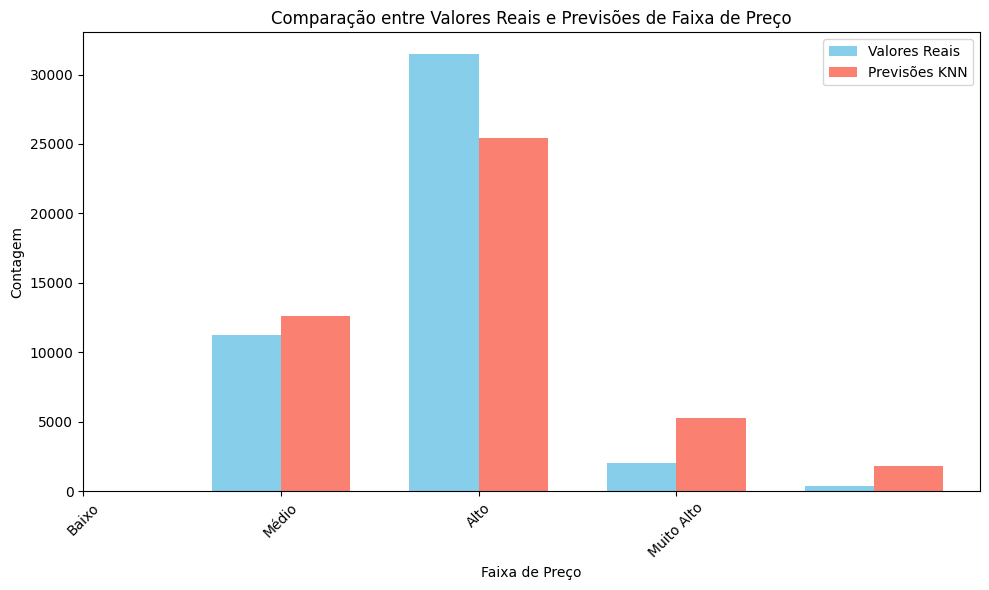

In [12]:
# Modelo Knn

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 10, 15, 20, 30, 50],  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

# Realizar GridSearch com validação cruzada
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Melhores Parâmetros:", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Relatório de Classificação (com melhores parâmetros):")
print(classification_report(y_test, y_pred))
print("Acurácia (com melhores parâmetros):")
print(accuracy_score(y_test, y_pred))

# Gráfico de comparação entre valores reais e previsões
real_counts = y_test.value_counts()
pred_counts = pd.Series(y_pred).value_counts()

labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']
width = 0.35 
plt.figure(figsize=(10, 6))

plt.bar(real_counts.index - width/2, real_counts, width=width, label='Valores Reais', color='skyblue')
plt.bar(pred_counts.index + width/2, pred_counts, width=width, label='Previsões KNN', color='salmon')
plt.title("Comparação entre Valores Reais e Previsões de Faixa de Preço")
plt.xlabel("Faixa de Preço")
plt.ylabel("Contagem")
plt.xticks(range(4), labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_1016\3471617877.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['city'] = label_encoder.fit_transform(X['city'])


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Melhores Parâmetros (Random Forest): {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Relatório de Classificação (Random Forest):
              precision    recall  f1-score   support

         1.0       0.52      0.47      0.49      7476
         2.0       0.81      0.51      0.62     21001
         3.0       0.09      0.21      0.13      1334
         4.0       0.01      0.31      0.02       238

    accuracy                           0.48     30049
   macro avg       0.36      0.37      0.32     30049
weighted avg       0.70      0.48      0.56     30049

Acurácia (Random Forest): 0.4833771506539319


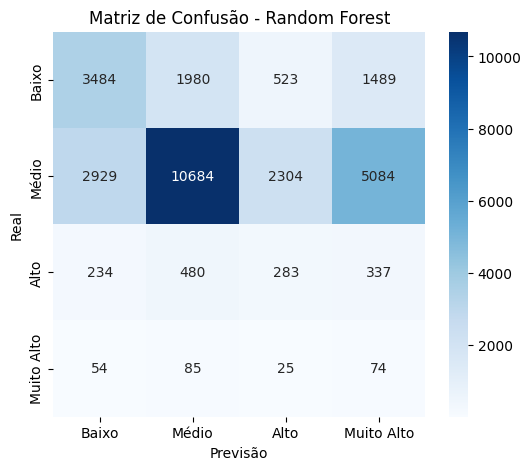

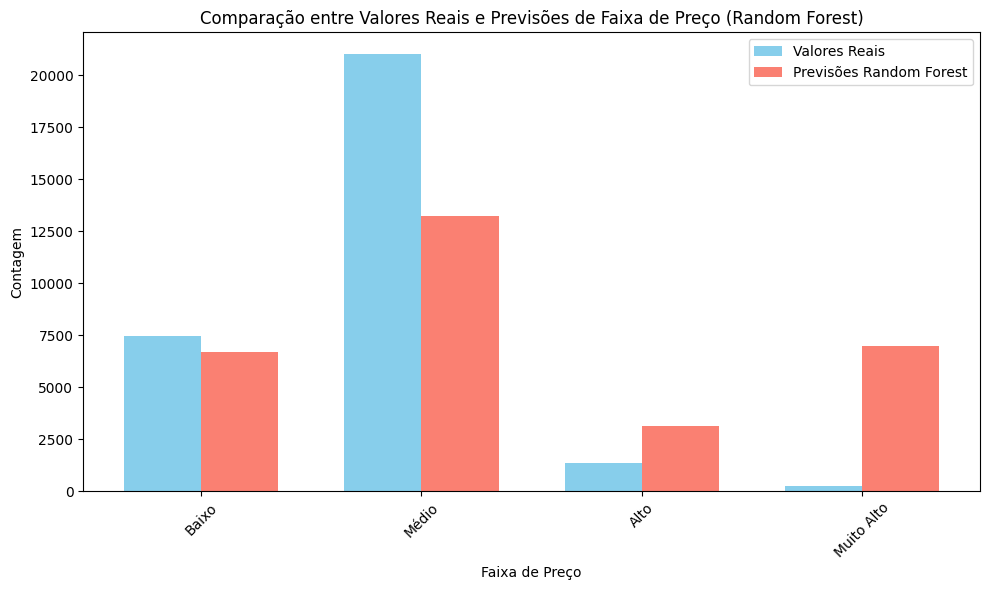

In [ ]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# Carregar o dataset
df_negocios = pd.read_parquet('./dataset/yelp_academic_dataset_business_cleaned.parquet')

features = ['stars', 'review_count', 'latitude', 'longitude', 'city']
X = df_negocios[features]
y = df_negocios['RestaurantsPriceRange2']

# Codificação da coluna categórica 'city'
label_encoder = LabelEncoder()
X['city'] = label_encoder.fit_transform(X['city'])

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Correção: Agora a divisão dos dados é idêntica à dos outros modelos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=1)

# ✅ Correção: Aplicação de SMOTE apenas no conjunto de treino
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Modelo Random Forest
rf = RandomForestClassifier(random_state=1)

param_grid = {
    'n_estimators': [100],  
    'max_depth': [10], 
    'min_samples_split': [10], 
    'min_samples_leaf': [4],  
    'bootstrap': [True],  
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

# GridSearch com menos combinações para reduzir tempo
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Melhor modelo
print("Melhores Parâmetros (Random Forest):", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Exibir relatório de classificação
print("Relatório de Classificação (Random Forest):")
print(classification_report(y_test, y_pred_rf))
print("Acurácia (Random Forest):", accuracy_score(y_test, y_pred_rf))

# 🔵 Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = ['Baixo', 'Médio', 'Alto', 'Muito Alto']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.show()

# 🔴 Comparação de contagens
real_counts_rf = y_test.value_counts()
pred_counts_rf = pd.Series(y_pred_rf).value_counts()

plt.figure(figsize=(10, 6))
width = 0.35

plt.bar(real_counts_rf.index - width/2, real_counts_rf, width=width, label='Valores Reais', color='skyblue')
plt.bar(pred_counts_rf.index + width/2, pred_counts_rf, width=width, label='Previsões Random Forest', color='salmon')
plt.title("Comparação entre Valores Reais e Previsões de Faixa de Preço (Random Forest)")
plt.xlabel("Faixa de Preço")
plt.ylabel("Contagem")
plt.xticks(range(1, 5), labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
